Point 4
in this part we instantiate an auction in the social network and we try to estimate the best set of bids with a Upper confidence and Thompson sampling approach.
in particular we have 10 advertiser that participate, 9 of them have a stochstic behaviour

In [19]:
from SocialNetwork.social_network_environment import *
from SocialNetwork.cascade import *
from Advertising.enviroment.bid import *
from Advertising.enviroment.VCG import *
from Advertising.learners.TSLearner import *
from Advertising.learners.UCB_Learner import *
from tqdm.autonotebook import tqdm

random.seed(1234)


In [20]:
#control if the learner is present in all auction and compute the correspondent reward
def reward_control_allocation(best_allocation, ad_id, reward):
    temp = []
    for i in range(5):
        control = False
        for j in range(len(best_allocation[i])):
            if (best_allocation[i][j].ad_id == ad_id):
                control = True
                break
        if control:
            temp.append(reward)
        else:
            temp.append(0)
    return temp


In [21]:
def test(n_test=1000, learner=None, vcg=None, social_network=None, lambdas=[]):
    collected_tot = []
    bids_adversaries = []
    for i in range(0, 5):
        bid_categoria = np.array([])
        for j in range(0, 10):  # number of competitors
            bid = Bid(bid=random.randint(1, 4), id=j+3)
            bid_categoria = np.append(bid_categoria, bid)
        bids_adversaries.append(bid_categoria)

    count_presence=np.zeros(5)    
     
    for i in tqdm(range(n_test)):

        #creation of the stochstic advertisers
       

        pulled_arm = learner.pull_arm()
        # add the bids of the learner into the auction
        for j in range(5):
            bids_adversaries[j][0] = pulled_arm[j]
    #the vgc calculate the best allocation        
        best_allocation = vcg.all_best_allocations(
            list_camp_bids=bids_adversaries, social_network=social_network)


        #linea di controllo per controllare che effettivamente ci sia nell'asta    
        for n in range(5):
            for m in range(6):
                if(best_allocation[n][m].ad_id==1):
                    count_presence[n]+=1



    # ACTIVATE THE CASCADE OF OUR SOCIAL NETWORK AND COMPUTE THE REWARDS
        reward = activate_cascade(social_network=social_network,
                                  ad_allocation_list=best_allocation, slot_prominence=lambdas)[0]
    # with this part of code i set that if the learner is present in the allocation list then get the normal allocation
    # reward, if it's not present and it bids 0 then the reward is 0.

        temp = np.array(reward_control_allocation(best_allocation, 1, reward))
        
        payments = np.array(vcg.payments(
            bids_adversaries, best_allocation, social_network=social_network))
        rew=np.sum(temp)/5-np.sum(payments)   
    # updating of the learners
        learner.update(pulled_arm,rew)
        collected_tot.append(rew)

    #printing the reward of the learner    
    plt.figure(0)
    plt.plot(np.cumsum(max_reward(social_network)-np.array(collected_tot)), 'r')
    plt.show()


    
    print("la percentuale di volte in cui c'è il learner è: ", count_presence/n_test)

100%|██████████| 1000/1000 [00:04<00:00, 217.21it/s]


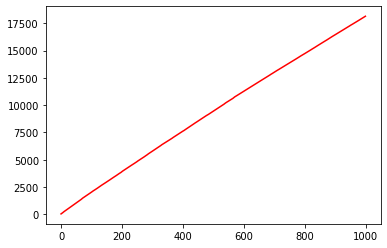

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/matteomainardi/Library/Mobile Documents/com~apple~CloudDocs/github/DirezioneInvestigativaAntimafia-DIA-/Advertising/learners/UCB_Learner.py:37: RuntimeWarning: invalid value encountered in double_scalars
  2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
/Users/matteomainardi/Library/Mobile Documents/com~apple~CloudDocs/github/DirezioneInvestigativaAntimafia-DIA-/Advertising/learners/UCB_Learner.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
  1%|          | 8/1000 [00:00<00:12, 79.68it/s]

la percentuale di volte in cui c'è il learner è:  [0.951 0.918 0.909 0.186 0.545]


100%|██████████| 1000/1000 [00:03<00:00, 270.61it/s]


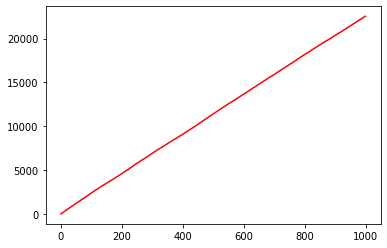

la percentuale di volte in cui c'è il learner è:  [0.88  0.88  0.051 0.88  0.88 ]


In [22]:
#setting of the environment for the test
prev_reward = 0
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')
lambdas = [0.9, 0.85, 0.7, 0.40, 0.35, 0.20]
arms = np.array([0,1,2,3,4])
vcg = VCG()

n_experiments=1000


ts_learner = TS_Learner(n_arms=len(arms), arms=arms, n_categories=5, ad_id=1)
ts_learner.max=max_reward(social_network)
ucb_learner = UCB_Learner(n_arms=len(arms), arms=arms, n_categories=5, ad_id=1)
test(n_experiments, ts_learner, vcg, social_network, lambdas)
test(n_experiments, ucb_learner,vcg, social_network, lambdas)

In [23]:
ts_learner.pull_arm()

[(bid=2, id=1), (bid=4, id=1), (bid=1, id=1), (bid=0, id=1), (bid=3, id=1)]

In [24]:
ucb_learner.pull_arm()

[(bid=2, id=1), (bid=2, id=1), (bid=2, id=1), (bid=2, id=1), (bid=2, id=1)]

Testing for Slicing Windows

In [25]:
class TS_SW_Learner:
    def __init__(self, n_arms, arms, n_categories, ad_id):
        self.ad_id = ad_id
        self.arms = arms
        self.n_categories = n_categories
        self.beta_parameters = np.ones((n_categories, n_arms, 2))
        self.n_arms = n_arms
        self.t = 0
        self.collected_rewards = []
        self.prev_reward = np.zeros(n_categories)
        self.max = 40
        self.isSw = False
        self.sizeSw = 0
        self.rewards_per_arm = []

    def update_observations(self, pulled_arm, reward):
        self.collected_rewards.append(reward)

    def pull_arm(self):
        bid = []
        values = np.random.beta(
            self.beta_parameters[:, :, 0], self.beta_parameters[:, :, 1])
        value_bid = np.argmax(values, axis=-1)
        value_bid = self.arms[value_bid]
        for i in range(len(value_bid)):
            bid.append(Bid(value_bid[i], self.ad_id))
        return bid

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        for i in range(self.n_categories):
            rew = reward/self.max
            if not self.isSw:
                #
                self.beta_parameters[i, pulled_arm[i].bid, 0] += rew
                self.beta_parameters[i, pulled_arm[i].bid, 1] += 1.0 - rew
            else:
                # implementation of slicing window update
                self.rewards_per_arm[i][pulled_arm[i].bid].append(rew)

                cum_rew = np.sum(
                    self.rewards_per_arm[i][pulled_arm[i].bid][-self.sizeSW:]
                )
                n_rounds_arm = len(
                    self.rewards_per_arm[i][pulled_arm[i].bid][-self.sizeSW:])

                self.beta_parameters[i, pulled_arm[i].bid, 0] += cum_rew + 1.0
                self.beta_parameters[i, pulled_arm[i].bid,
                                     1] += n_rounds_arm - cum_rew + 1.0

    def activateSW(self, sizeSW=40):
        self.isSw = True
        self.sizeSW = sizeSW
        self.rewards_per_arm = [
            [[] for j in range(self.n_arms)] for i in range(self.n_categories)]


In [26]:
class UCB_SW_Learner():
    def __init__(self, n_arms, arms, n_categories, ad_id):
        self. n_arms = n_arms
        self.n_categories = n_categories
        self.ad_id = ad_id
        self.arms=arms
        # sum of reward of each arm in each category
        self.reward_per_arm = np.zeros((n_categories, n_arms))
        self.empirical_mean = np.ones((n_categories, n_arms))
        self.confidence = np.ones((n_categories, n_arms))*np.inf
        # counting of how many time an arm in pulled in each category
        self.count = np.zeros((n_categories, n_arms))
        self.collected_rewards = []
        self.t = 0  # number of executions
        self.c = 5.0  # exploration factor
        self.isSW = False
        self.sizeSW = 0
        self.rewards_per_arm = []
        self.count_for_sw = []

    def pull_arm(self):
        ucb = self.empirical_mean+self.confidence
        pulled_arm = np.argmax(ucb, axis=-1)
        pulled_arm = self.arms[pulled_arm]
        bids = [Bid(pulled_arm[i], self.ad_id) for i in range(5)]
        return bids

    def update(self, pulled_arm, reward):
        self.t += 1

        self.collected_rewards.append(reward)
        for i in range(self.n_categories):

            if not self.isSW:
                self.reward_per_arm[i][pulled_arm[i].bid] += reward
                self.count[i][pulled_arm[i].bid] += 1
            # computation empirical mean reward and confidence
                self.empirical_mean[i][pulled_arm[i].bid
                                       ] = self.reward_per_arm[i][pulled_arm[i].bid]/self.count[i][pulled_arm[i].bid]
                self.confidence[i][pulled_arm[i].bid] = self.c*np.sqrt(
                    2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
            # improvement to force the pulling of all arm
            else:
                for k in range(self.n_categories):
                    for l in range(len(self.count_for_sw[k])):
                        if l == pulled_arm[i].bid:
                            self.self.count_for_sw[k][l].append(1)
                        else:
                            self.self.count_for_sw[k][l].append(0)
                self.rewards_per_arm[i][pulled_arm[i].bid].append(reward)
                count_rew = np.sum(
                    self.rewards_per_arm[i][pulled_arm[i].bid][-self.sizeSW:])
                num_exp = len(
                    self.rewards_per_arm[i][pulled_arm[i].bid][-self.sizeSW:])

                self.empirical_mean[i][pulled_arm[i].bid
                                       ] = count_rew/num_exp
                
                countsw = np.sum(np.sum(
                    self.count_for_sw[i][pulled_arm[i].bid][-self.sizeSW:]))
                self.confidence = self.c*np.sqrt(
                    2*np.log(self.t)/(countsw-1))
        for i in range(self.n_categories):
            self.empirical_mean[i][self.count[i] == 0] = np.inf
            self.confidence[i][self.count[i] == 0] = np.inf

    def activateSW(self, sizeSW=40):
        self.isSw = True
        self.sizeSW = sizeSW
        self.rewards_per_arm = [
            [[] for j in range(self.n_arms)] for i in range(self.n_categories)]
        self.count_for_sw = [
            [[] for j in range(self.n_arms)] for i in range(self.n_categories)]


In [27]:
def test_sw(n_test=1000, learner=None, vcg=None, sizeSW=300, social_network=None, lambdas=[]):
    collected_tot = []
    count_sw = 1000
    count_presence = np.zeros(5)

    sel = 0
    for i in tqdm(range(n_test)):
        count_sw += 1
        # creation of the stochastic advertisers
        if count_sw >= sizeSW:
            bids_adversaries = []
            for k in range(0, 5):
                bid_categoria = np.array([])
                for j in range(0, 10):  # number of competitors
                    bid = Bid(bid=random.randint(1, 4), id=j+3)
                    bid_categoria = np.append(bid_categoria, bid)
                bids_adversaries.append(bid_categoria)
            count_sw=0    

        pulled_arm = learner.pull_arm()
        # add the bids of the learner into the auction
        for j in range(5):
            bids_adversaries[j][0] = pulled_arm[j]
    # the vgc calculate the best allocation
        best_allocation = vcg.all_best_allocations(
            list_camp_bids=bids_adversaries, social_network=social_network)
   #linea di controllo per controllare che effettivamente ci sia nell'asta
        for n in range(5):
            for m in range(6):
                if(best_allocation[n][m].ad_id == 1):
                    count_presence[n] += 1

    # ACTIVATE THE CASCADE OF OUR SOCIAL NETWORK AND COMPUTE THE REWARDS
        reward = activate_cascade(social_network=social_network,
                                  ad_allocation_list=best_allocation, slot_prominence=lambdas)[0]
    # with this part of code i set that if the learner is present in the allocation list then get the normal allocation
    # reward, if it's not present and it bids 0 then the reward is 0.

        temp = np.array(reward_control_allocation(best_allocation, 1, reward))

        payments = np.array(vcg.payments(
            bids_adversaries, best_allocation, social_network=social_network))
        rew = np.sum(temp)/5-np.sum(payments)
    # updating of the learners
        learner.update(pulled_arm, rew)
        collected_tot.append(rew)

    #printing the reward of the learner
    plt.figure(0)
    plt.plot((max_reward(social_network)-np.array(collected_tot)), 'r')
    plt.show()


100%|██████████| 2000/2000 [00:09<00:00, 218.74it/s]


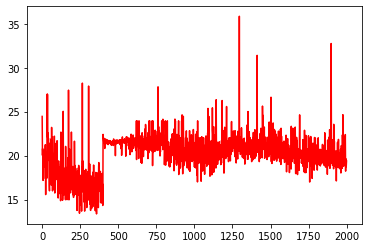

  0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-26-6c7a898d910d>:41: RuntimeWarning: invalid value encountered in double_scalars
  2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
<ipython-input-26-6c7a898d910d>:41: RuntimeWarning: divide by zero encountered in double_scalars
  2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
100%|██████████| 2000/2000 [00:06<00:00, 329.94it/s]


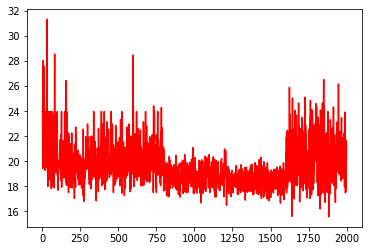

In [28]:
prev_reward = 0
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')
lambdas = [0.9, 0.85, 0.7, 0.40, 0.35, 0.20]
arms = np.array([0, 1, 2, 3, 4])
vcg = VCG()

n_experiments = 2000
random.seed(1234)


ts_learner = TS_SW_Learner(n_arms=len(arms), arms=arms, n_categories=5, ad_id=1)
ts_learner.max = max_reward(social_network)
ucb_learner = UCB_SW_Learner(n_arms=len(arms), arms=arms, n_categories=5, ad_id=1)

ts_learner.activateSW(sizeSW=400)
ucb_learner.activateSW(sizeSW=400)

test_sw(n_experiments, ts_learner, vcg,400 , social_network, lambdas)
test_sw(n_experiments, ucb_learner, vcg,400, social_network, lambdas)
